Partly based on notebook by Chris Morrison 
https://github.com/LSSTDESC/pz_calibrate/blob/master/doc/notebooks/SelectDESIReferenceSamples.ipynb

In [516]:
import numpy as np
from matplotlib import pyplot as plt
import GCRCatalogs
from GCR import GCRQuery
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.stats import normaltest
from scipy.interpolate import interp1d as itp
from scipy.optimize import curve_fit
import pandas
import matplotlib.colors as clr
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from  magnification_library import *

In [4]:
catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image_photoz_calib');

/pbs/throng/lsst/software/desc/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/GCRCatalogs/register.py:395: UserWarning: `cosmoDC2_v1.1.4_image_photoz_calib` has been deprecated and may be removed in the future.
This catalog has been renamed as `cosmoDC2_v1.1.4_image_with_photoz_calib`; use the new catalog name instead.
If your analysis requires this specific catalog, please open an issue at https://github.com/LSSTDESC/gcr-catalogs/issues
  f"`{self.rootname}` has been deprecated and may be removed in the future.\n{deprecation_msg}"


In [214]:
cosmo = catalog.cosmology

In [5]:
#catalog.list_all_quantities()

In [7]:
quantities = ['ra', 'dec','redshift','halo_mass','halo_id', 'is_central','mag_r_lsst','mag_i_lsst','mag_Y_lsst','Mag_true_u_lsst_z0','Mag_true_g_lsst_z0','Mag_true_i_lsst_z0', 'QSO', 'LRG', 'ELG']
#native_filters = ['healpix_pixel < 9100']
filters = ['QSO==True']
DESI_like_data = catalog.get_quantities(quantities, filters=filters)#, native_filters = native_filters)

In [486]:
QSO = (DESI_like_data['QSO']==True)
ELG = (DESI_like_data['ELG']==True)
LRG = (DESI_like_data['LRG']==True)

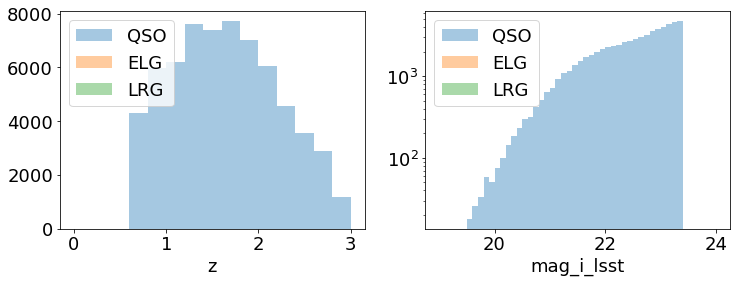

In [487]:
fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(12,4), sharex=False)

nbins = 15
qso_zhist = ax1.hist(DESI_like_data['redshift'][QSO],bins=nbins, range = [0,3.],alpha=0.4, label = ['QSO']);
ax1.hist(DESI_like_data['redshift'][ELG],bins=nbins,range = [0,3.],alpha=0.4, label = ['ELG']);
ax1.hist(DESI_like_data['redshift'][LRG],bins=nbins,range = [0,3.],alpha=0.4, label = ['LRG']);

ax1.legend()
ax1.set_xlabel('z')

qso_hist = ax2.hist(DESI_like_data['mag_r_lsst'][QSO],bins=50,alpha=0.4, range = [19,24], label = ['QSO']);
ax2.hist(DESI_like_data['mag_r_lsst'][ELG],bins=50,alpha=0.4, range = [19,24], label = ['ELG']);
ax2.hist(DESI_like_data['mag_r_lsst'][LRG],bins=50,alpha=0.4, range = [19,24], label = ['LRG']);
ax2.legend()
ax2.set_xlabel('mag_i_lsst')
ax2.semilogy();


z_bin_cen = qso_zhist[1][:-1]+(qso_zhist[1][1] - qso_zhist[1][0])/2;


# QSO redshift distribution

## Comparison to DESI expectations
- https://arxiv.org/pdf/1611.00036.pdf

In [488]:
#values from Table 2.3 and Table 2.7 in https://arxiv.org/pdf/1611.00036.pdf

bin_edges = np.concatenate(    [np.arange(0.60, 1.95, 0.1),
     [2.02, 2.22, 2.34, 2.52, 2.66,
      2.84, 2.98, 3.16, 3.30, 3.48,
      3.62, 3.78, 3.94, 4.10]])
delta_zs = bin_edges[1:] - bin_edges[:-1]

# Initial density values are in units, N / (deg^2 dz)
QSO_density = np.array(
    [47, 55, 61, 67, 72, 76, 80, 83,
     85, 87, 87, 87, 86, 82, 69, 53,
     43, 37, 31, 26, 21, 16, 13,  9,
      7,  5,  3]) 

In [491]:
#values extracted manually from baseline in Fig 3.17 in https://arxiv.org/pdf/1611.00036.pdf

nc = pandas.read_csv('cluster_magnification/DESI_number_counts_extracted_Fig3p17_DESIexpP1.csv')

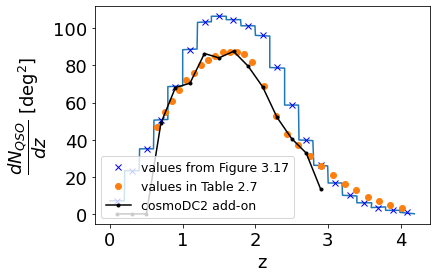

In [492]:
plt.plot(nc['z'], nc["nz_dz"]/nc['z'][1])
plt.plot(nc['z'][::2]+0.5*nc['z'][1], nc["nz_dz"][::2]/nc['z'][1],'bx',  label='values from Figure 3.17')

plt.plot(bin_edges[:-1] + delta_zs / 2.0, QSO_density, 'o', label='values in Table 2.7')

plt.plot(z_bin_cen,qso_zhist[0]/catalog.sky_area / (z_bin_cen[1] - z_bin_cen[0]),'k.-', label='cosmoDC2 add-on') 

plt.xlabel('z')
plt.ylabel('$\dfrac{dN_{QSO}}{dz}$ [deg$^2$]')
plt.legend(fontsize='x-small')

## Parametrisation of the QSO redshift distribution

In [493]:
def pdf_z(z, alpha, beta, z0):
    """Redshift distribution function"""
    #alpha, beta, z0 = 1.24, 1.01, 0.51
    return (z**alpha)*np.exp(-(z/z0)**beta)

In [494]:
def pdf_z_trunc(z, alpha, beta, z0):
    """Redshift distribution function"""
    #alpha, beta, z0 = 1.24, 1.01, 0.51
    return np.heaviside((z>0.5),0)*(z**alpha)*np.exp(-(z/z0)**beta)

In [495]:
zrange = (z_bin_cen>0.5)
p0 = (1.24, 1.01, 0.51)

popt1, pcov1 = curve_fit(pdf_z, z_bin_cen[zrange],qso_zhist[0][zrange]/ np.sum(qso_zhist[0][zrange]), p0=p0 , maxfev=2000 )
print (popt1)
print (pcov1)
#same results if we use pdf_z_trunc instead

popt2, pcov2 = curve_fit(pdf_z, bin_edges[:-1] + delta_zs / 2.0, QSO_density/np.sum(QSO_density), p0=p0 , maxfev=2000 )
print (popt2)
print (pcov2)

popt3, pcov3 = curve_fit(pdf_z, nc['z'][::2]+0.5*nc['z'][1], nc["nz_dz"][::2]/np.sum(nc["nz_dz"][::2]), p0=p0 , maxfev=2000 )
print (popt3)
print (pcov3)

[3.55579301 1.06793002 0.45766749]
[[0.08035266 0.01116942 0.00242313]
 [0.01116942 0.00221554 0.0007303 ]
 [0.00242313 0.0007303  0.0003163 ]]
[3.8338536  0.93783884 0.31593764]
[[2.27355633e-02 2.69209498e-03 8.06963685e-04]
 [2.69209498e-03 4.40415457e-04 1.66582577e-04]
 [8.06963685e-04 1.66582577e-04 7.14989112e-05]]
[3.93923455 1.05372306 0.42087706]
[[0.06709515 0.00715287 0.00118895]
 [0.00715287 0.00128468 0.00044364]
 [0.00118895 0.00044364 0.00022089]]


(0.0, 150.0)

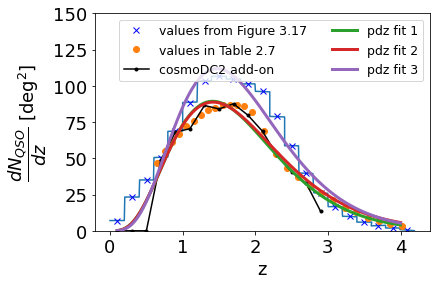

In [496]:
plt.plot(nc['z'], nc["nz_dz"]/nc['z'][1])
plt.plot(nc['z'][::2]+0.5*nc['z'][1], nc["nz_dz"][::2]/nc['z'][1],'bx',  label='values from Figure 3.17')

plt.plot(bin_edges[:-1] + delta_zs / 2.0, QSO_density, 'o', label='values in Table 2.7')

plt.plot(z_bin_cen,qso_zhist[0]/catalog.sky_area / (z_bin_cen[1] - z_bin_cen[0]),'k.-', label='cosmoDC2 add-on') 


z =  np.linspace(0.1, 4,100)

plt.plot(z, pdf_z(z, *popt1) * np.sum(qso_zhist[0][zrange])/catalog.sky_area / (z_bin_cen[1] - z_bin_cen[0]), lw=3, label = 'pdz fit 1' )
plt.plot(z, pdf_z(z, *popt2) * np.sum(QSO_density), lw=3, label = 'pdz fit 2')
plt.plot(z, pdf_z(z, *popt3) * np.sum(nc["nz_dz"][::2])/nc['z'][1], lw=3, label = 'pdz fit 3')



plt.xlabel('z')
plt.ylabel('$\dfrac{dN_{QSO}}{dz}$ [deg$^2$]')
plt.legend(fontsize='x-small',ncol=2)
plt.ylim(0,150)

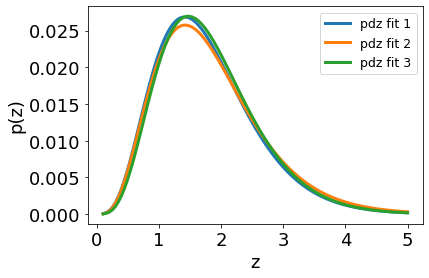

In [497]:
z =  np.linspace(0.1, 5,100)

plt.plot(z, pdf_z(z, *popt1)/np.sum(pdf_z(z, *popt1)), lw=3, label = 'pdz fit 1' )
plt.plot(z, pdf_z(z, *popt2)/np.sum(pdf_z(z, *popt2)), lw=3, label = 'pdz fit 2')
plt.plot(z, pdf_z(z, *popt3)/np.sum(pdf_z(z, *popt3)), lw=3, label = 'pdz fit 3')



plt.xlabel('z')
plt.ylabel('p(z)')
plt.legend(fontsize='x-small',ncol=1)

In [498]:
print("The baseline parameters for QSO redshift distribution are :",  popt2)

The baseline parameters for QSO redshift distribution are : [3.8338536  0.93783884 0.31593764]


# Measurement of the slope of the QSO LF

In [499]:
# Fit of the luminosity function

In [500]:
def linear(magnitude, a, b, c):
    "linear fit"
    return (magnitude - c)* a + b

In [501]:
mag_bin_cen = qso_hist[1][:-1]+(qso_hist[1][1] - qso_hist[1][0])/2

mrange = (mag_bin_cen<23.4)
p0 = (qso_hist[0][20], -1., 21)
popt, pcov = curve_fit(schechterM, mag_bin_cen[mrange],qso_hist[0][mrange], p0=p0 , maxfev=2000 )
print (popt)

[ 2.48320384e+03 -1.40729703e+00  2.10877693e+01]


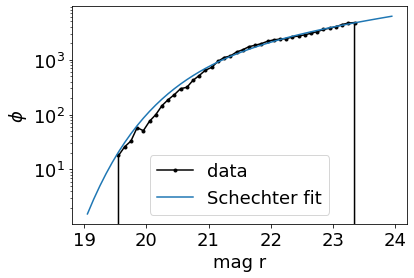

In [502]:
mag_bin_cen = qso_hist[1][:-1]+(qso_hist[1][1] - qso_hist[1][0])/2

plt.plot(mag_bin_cen,qso_hist[0],'k.-', label='data') 
plt.semilogy()
plt.xlabel("mag r")
plt.ylabel("$\\phi$")

plt.plot(mag_bin_cen, schechterM(mag_bin_cen, *popt), label = 'Schechter fit' )

plt.legend()

/pbs/throng/lsst/software/desc/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


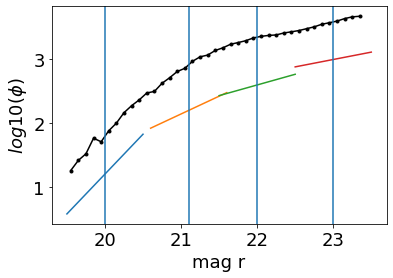

In [503]:
plt.plot(mag_bin_cen, np.log10(qso_hist[0]),'k.-', label='data') 
plt.xlabel("mag r")
plt.ylabel("$log10(\\phi)$")

c = 20
xrange = np.linspace(c - 0.5, c + 0.5, 10)
plt.plot(xrange, linear(xrange, slope(c, popt[1], popt[2]), 1.2, c))
plt.axvline(c)

c = 21.1
xrange = np.linspace(c - 0.5, c + 0.5, 10)
plt.plot(xrange, linear(xrange, slope(c, popt[1], popt[2]), 2.2, c))
plt.axvline(c)


c = 22
xrange = np.linspace(c - 0.5, c + 0.5, 10)
plt.plot(xrange, linear(xrange,  slope(c, popt[1], popt[2]), 2.6, c))
plt.axvline(c)

c = 23.
xrange = np.linspace(c - 0.5, c + 0.5, 10)
plt.plot(xrange, linear(xrange,  slope(c, popt[1], popt[2]), 3., c))
plt.axvline(c)

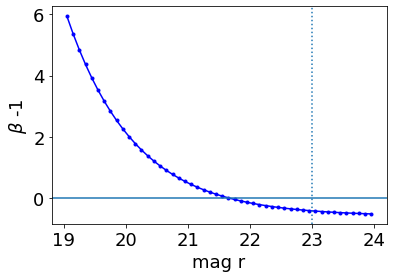

In [504]:
plt.plot(mag_bin_cen, 2.5*slope(mag_bin_cen, popt[1], popt[2]) - 1, 'b.-')
plt.xlabel("mag r")
plt.ylabel("$\\beta$ -1")

plt.axvline(23, linestyle="dotted")

plt.axhline(0)

In [505]:
mlimr = 23.
fct = "schechter"
band = "r"

print("slope at mag = mag_lim", slope(mlimr, popt[1], popt[2]))

#alphazr, Mstarzr = LF_param(z, alpha , 0, mstar, 0, method="Faber07")[0:2]

slope at mag = mag_lim 0.23165219326358708


/pbs/throng/lsst/users/mricci/desc/Magnification_project/magnification_library.py:263: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Kcorr=="simple":


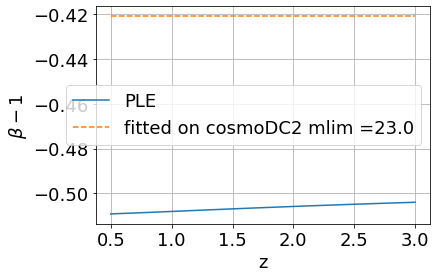

In [507]:
#https://www.aanda.org/articles/aa/pdf/2017/12/aa31850-17.pdf
alpha = -3.16
beta = -1.49
mstar = -25.95

mlim = 23.
fct = "PLE_LEDE2"
band = "g"

z =  np.linspace(0.5, 3,10)

alphaz, betaz = np.ones(z.size)*alpha, np.ones(z.size)*beta
Mstarz = mstar - 1.37 * 2.5*np.log10(1+z - np.sqrt(1+z))

Mlim = mlim_to_Mlim(mlim, z, cosmo, -2.5*0.5*np.log10(1+z))
mslope_z = slope(Mlim, alphaz, Mstarz, betaz, fct="PLE")
plt.plot(z, 2.5 * mslope_z - 1, label='PLE')

plt.plot(z, 2.5 * slope(mlimr, popt[1], popt[2])- np.ones(z.size), '--', label = 'fitted on cosmoDC2 mlim ='  + str(mlim))


plt.xlabel('z')
plt.ylabel('$\\beta - 1$');
plt.legend()
plt.grid()

In [524]:
2.5*itp.interp1d(z, mslope_z)(1.3)

0.4925703023985243

In [263]:
print("The baseline parameter for QSO LF is : \\beta/2.5 = ",  0.197)

The baseline parameter for QSO LF is : \beta/2.5 =  0.197


### Variation of the slope with redshift in cosmoDC2

In [155]:
low_z = DESI_like_data['redshift']<1.5
high_z = DESI_like_data['redshift']>1.5

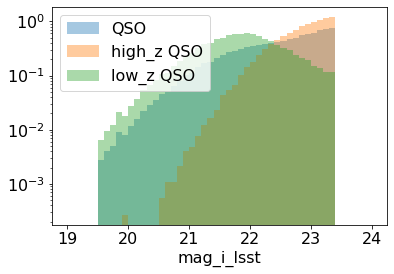

In [156]:

qso_hist = plt.hist(DESI_like_data['mag_r_lsst'][QSO],bins=50,alpha=0.4,density='True', range = [19,24], label = ['QSO']);
qso_hz_hist = plt.hist(DESI_like_data['mag_r_lsst'][QSO*high_z],bins=50,alpha=0.4, density='True',range = [19,24], label = ['high_z QSO']);
qso_lz_hist = plt.hist(DESI_like_data['mag_r_lsst'][QSO*low_z],bins=50,alpha=0.4,density='True', range = [19,24], label = ['low_z QSO']);

plt.legend()
plt.xlabel('mag_i_lsst')
plt.semilogy();


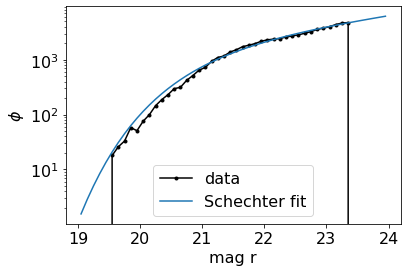

In [266]:
plt.plot(mag_bin_cen,qso_hist[0],'k.-', label='data') 
plt.semilogy()
plt.xlabel("mag r")
plt.ylabel("$\\phi$")

plt.plot(mag_bin_cen, schechterM(mag_bin_cen, *popt), label = 'Schechter fit' )

plt.legend()

/pbs/throng/lsst/software/desc/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


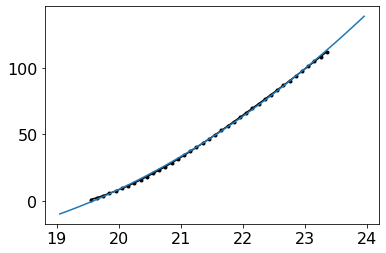

In [345]:

plt.plot(mag_bin_cen[5:44],np.nancumsum(np.log10(qso_hist[0])[5:44]),'k.-', label='data') 

plt.plot(mag_bin_cen, polyn(mag_bin_cen,*popt0))

In [342]:
def polyn(x, a, b, c):
    p = 0.5*a * x**2 + b * x + c
    return p 

In [344]:
p0 = (0,-1,-1)
popt0, pcov0 = curve_fit(polyn, mag_bin_cen[5:44],np.nancumsum(np.log10(qso_hist[0])[5:44]), p0=p0 , maxfev=2000 )
print (popt0)

[  5.52663997 -88.59372565 675.35664563]


/pbs/throng/lsst/software/desc/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [405]:
2.5 * slope(23,popt[1], popt[2])

0.5791304831589676

In [347]:
2.5 * popt0[0]*23+popt0[1]

229.18807276600148

In [427]:
popt
popt = [150, -1.2, 19]

In [468]:
test = np.random.choice(np.linspace(19,27,1000), size=10000, p = schechterM(np.linspace(19,27,1000), *popt) / np.sum(schechterM(np.linspace(19,27,1000), *popt) ))

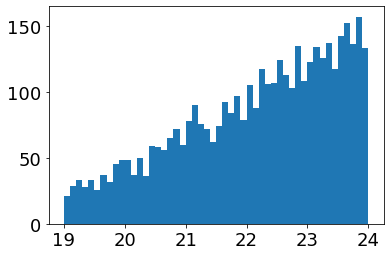

In [469]:
plt.hist(test,range=[19,24], bins=50);

In [470]:
import treecorr
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
import GCRCatalogs
from GCR import GCRQuery
import healpy
import astropy.units as u
import magnification_library
from scipy.optimize import curve_fit
import scipy.interpolate as itp
from scipy import stats
import matplotlib
import pandas as pd
matplotlib.rcParams.update({'font.size': 18})

In [471]:
def alpha_derivation(mag, mmin, mmax, binsize, mag_lim, show_plots='False'):
    
    nbins = int((mmax - mmin)/binsize)
    mag_hist = stats.cumfreq(mag, numbins=nbins, defaultreallimits=[mmin,mmax])
    #mag_hist = plt.hist(gal_cat['mag_i_lsst'],bins=nbins, range=[mmin,mmax], cumulative=True, label='all');
    
    N = mag_hist.cumcount[mag_hist.cumcount>0]
    #N = mag_hist[0][mag_hist[0]>0]
    mi = (np.linspace(mmin, mmax, nbins+1)[:-1] + binsize/2.)[mag_hist.cumcount>0]
    #mi = bin_center(mag_hist[1])[mag_hist[0]>0]
    logN = np.log10(N)
    
    step = int(0.5/binsize)
    param = np.zeros((3,mi.size - 2*step))
    dlogNdm = np.zeros((mi.size - 2*step))

    for j in range(mi.size - 2*step):
        i = j + step
        popt, pcov = curve_fit(polyn, mi[i-step:i+step], logN[i-step:i+step], maxfev=20000, p0=(0,0,0)) 
        param[:,j] = popt  
        dlogNdm[j] = popt[0]*mi[j]+popt[1]
        
    falpha = itp.interp1d(mi[step:-step], 2.5*dlogNdm)
    snr = (abs(falpha.y - 1)*np.sqrt(N[step:-step]))
    
    m_cut = falpha.x[np.argmax(snr[falpha.x<mag_lim])]
    alpha_cut = float(falpha(m_cut))
    
    y0, tol = 1., 1e-4 
    xnew = np.linspace(falpha.x.min(), falpha.x.max(), int(1e6))
    ind = np.where(abs(falpha(xnew) - y0) < tol)[0]
    s = xnew[ind]
    
    if s[s<mag_lim].size> 0:
        m_cut_null = np.max(s[s<mag_lim])
    else :
        m_cut_null = -1.
    
    #if show_plots:
    #    alpha_derivation_plots(mag, mmin, mmax, nbins, falpha, snr, mag_lim, m_cut, m_cut_null)
    
    return m_cut, alpha_cut, m_cut_null, falpha, snr

In [478]:
m_cut, alpha_cut, m_cut_null, falpha, snr = alpha_derivation(test, 19, 27, 0.1, 26., show_plots='True')

In [479]:
falpha(23)

array(0.52581926)

In [480]:
falpha(23)

array(0.52581926)

(0.0, 2.0)

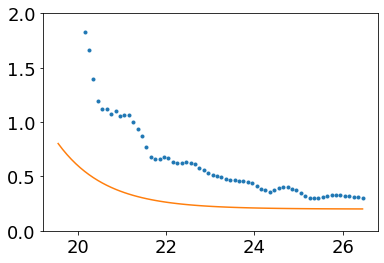

In [481]:
plt.plot(falpha.x, falpha.y,'.')
plt.plot(falpha.x, 2.5*slope(falpha.x,popt[1], popt[2]))

plt.ylim(0,2)

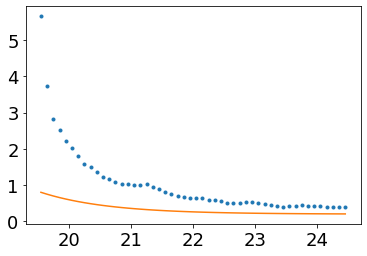

In [457]:
plt.plot(falpha.x, falpha.y,'.')
plt.plot(falpha.x, 2.5*slope(falpha.x,popt[1], popt[2]))

In [435]:
falpha.y / (2.5*slope(falpha.x,popt[1], popt[2]))

array([7.99708258, 5.38867391, 4.28679906, 3.71719403, 3.475852  ,
       3.35439052, 3.23770025, 3.21168424, 3.19449286, 3.08782894,
       2.91930626, 2.85443459, 2.84018252, 2.89421004, 2.96569297,
       3.03128575, 3.11201824, 3.18994537, 3.10571482, 2.92054044,
       2.71985655, 2.55609427, 2.47586503, 2.36830579, 2.3350654 ,
       2.37609808, 2.47963412, 2.53538313, 2.57030411, 2.57564847,
       2.50143898, 2.3904293 , 2.23210441, 2.12734071, 2.07519002,
       2.12763942, 2.15441917, 2.18368063, 2.15679718, 2.08585229])

In [425]:
falpha.y / (2.5*slope(falpha.x,popt[1], popt[2]))

array([1.20837234, 0.97600034, 0.84459642, 0.8745736 , 1.02346889,
       1.37942952, 1.64200163, 1.74278091, 1.63210481, 1.69972131,
       1.52111676, 1.57808612, 1.64479087, 1.8107418 , 1.88741762,
       1.86488549, 1.74173628, 1.73441991, 1.74877134, 1.77586107,
       1.78410056, 1.79489388, 1.80727335, 1.87236555, 1.87410733,
       1.88092126, 1.83049319, 1.76006738, 1.73985387, 1.67839038,
       1.68217807, 1.69438429, 1.69603681, 1.67851835, 1.66480622,
       1.70000866, 1.72314254, 1.77700055])